# Predicting my TRT 50 finish time using data

I'm running the [Tahoe Rim Trail 50](http://trter.com/). Part of my prep for an ultra is putting together a pace chart to help me figure out the best strategy to pace the race.

Andrew Skurka wrote a great [series of posts](http://andrewskurka.com/2017/create-pace-chart-ultra-marathon-tutorial-how-to/) about this; in the past I've followed a similar approach.

However, for the past few years, I've been tracking all my runs on Strava, and it occurred to me that there's a wealth of data there about how fast I'm able to run in various conditions. And, there's a fair bit of course data available about TRT, including some very high-quality race splits from last year.

So, this notebook shows how I took that data, analyzed it, and produced a pace chart. It's long and gets in the weeds at points, so here's a high-level summary of the steps involved:

1. Pull my historic data from Strava, filter it (only consider trail runs, and only those during this year's training block), and backfill missing temperature data. Analyze that data, and produce a regression model that allows me to predict future performances. This gives me a projected finish time and projected average pace.

2. Pull last year's splits from UltraSignup, and analyze the relative difficulty of each segment. That is, the race is far from flat (for example: there's a 1700' climb between miles 30 and 32 where I'll be moving _far_ slower than average), so to get more accurate projected splits I'll want to know how much harder or easier each bit is.

3. Apply the relative difficulties to my average pace to generate a pace chart.

To skip to the end, here's what I ended up with:


```
Aid Station          Dist.  Pace   Seg. Time  Elapsed   ETA   
-------------------  -----  -----  ---------  --------  --------
Start                0                                   6:00 am
Hobart (1)           7      14:21    1:40:28   1:40:28   7:40 am
Tunnel Creek (1)     12     14:21    1:11:45   2:52:13   8:52 am
Red House            15     14:21      43:03   3:35:17   9:35 am
Tunnel Creek (2)     18.5   14:21      50:14   4:25:31  10:25 am
Bull Wheel (1)       21.5   16:39      49:58   5:15:29  11:15 am
Diamond Peak         30     16:39    2:21:36   7:37:06   1:37 pm
Bull Wheel (2)       32     25:33      51:06   8:28:12   2:28 pm
Tunnel Creek (3)     35     25:33    1:16:40   9:44:52   3:44 pm
Hobart (2)           40     20:00    1:40:04  11:24:57   5:24 pm
Snow Valley Peak     43     20:00    1:00:02  12:25:00   6:25 pm
Spooner Summit       48.3   15:14    1:20:45  13:45:46   7:45 pm
Finish               50     15:14      25:54  14:11:40   8:11 pm
```

(I also generated split tables for a 95% confidance interval, giving an upper and lower bounds).

Read on to see the code and the gory details.

How accurate is this? We'll find out! I'll update this after the race to compare projected results with actual results.

# Preamble: Imports and Helpers

In [1]:
import attr
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from functools import lru_cache
from itertools import chain
from more_itertools import windowed
from pathlib import Path

sns.set()

def format_hms(td, fmt=None):
    """
    Format a time delta into H:M:S or H:M, etc.
    
    fmt is a str.format-style format string, containing "h", "m", "s"". 
    Minutes and seconds will be zero-padded.
    
    If fmt isn't given, default to {h}:{m}:{s} if the time is greater than an hour,
    or {m}:{s} if it's less.
    """
    if not fmt:
        fmt = "{h}:{m}:{s}" if td.total_seconds() >= 3600 else "{m}:{s}"
    h, rem = divmod(td.total_seconds(), 3600)
    m, s = divmod(rem, 60)
    return fmt.format(h=int(h), m=str(int(m)).rjust(2, "0"), s=str(int(s)).rjust(2, "0"))

@mpl.ticker.FuncFormatter
def hms_tickformater(x, pos):
    """Axis tick formatter to format seconds using above"""
    return format_hms(dt.timedelta(seconds=x))

/Users/jacobkaplan-moss/.pyenv/versions/jupyter3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Part 1: Predict target pace/finish time based on historic activity

First step: project an average pace and finish time based on data from my runs in this training block. The idea is to use data from my training runs to create a model that can predict my finish time for a race.

## Get activities from Strava

Strava is my source of truth on running data, so grab data from there. 

I only want to look at runs from the training block leading up to TRT. I don't want to use times when I was training for a road marathon, or data from last year when I may not have been as fit as I am this year. 

So I'll use March 13th as a date a week after Napa, when I'm starting to shift into ultra training. 

In [2]:
class Strava(requests.Session):
    def __init__(self, token):
        super().__init__()
        self.headers['Authorization'] = f'Bearer {token}'
        
    def get_activities_since(self, date):
        ts = int(date.timestamp())
        return self.get(f'https://www.strava.com/api/v3/athlete/activities?after={ts}&per_page=200').json()
    
    # We're going to make a lot of calls to get
    @lru_cache()
    def get_gear(self, gear_id):
        return self.get(f'https://www.strava.com/api/v3/gear/{gear_id}').json()

In [3]:
STRAVA_TOKEN = Path("~/.strava-token").expanduser().read_text().strip()
TRAINING_START_DATE = dt.datetime(2017, 3, 13)

strava = Strava(STRAVA_TOKEN)
activities = strava.get_activities_since(TRAINING_START_DATE)

### Only consider trail runs

I only want to consider trail runs. A reasonable way to tell the difference: look at the shoe. If it was a trail shoe, it was a trail run. This isn't perfect: I've done at least a couple of trail runs in my road shoe, and I have one shoe, the Gobi, that I use on both roads and trails. But it's pretty close, and I use trail shoes for all my long efforts, so it should be a good enough filter.

In [4]:
trail_shoes = ('Salomon S-Lab Sense 5 Ultra', 
               'Nike Terra Kiger 3', 
               'Salomon Sense PRO MAX', 
               'Hoka One One Speed Instinct')

activities = [
    a for a in activities 
    if a['type'] == 'Run' and strava.get_gear(a['gear_id'])['name'] in trail_shoes
]

### Convert into a `DataFrame`, and convert/munge data

Convert some fields:

- `distance` from meters to miles
- `total_elevation_gain`, and `elev_low` from meters to feet
- `average_temp` from Celsius to Fahrenheit
- `start_date` convert to a datetime

In [5]:
def convert_to_dataframe(activities):
    # Only include certain columns that have potentially relevent data.
    df = pd.DataFrame(activities, columns=['average_heartrate', 'distance', 'moving_time', 
                                           'elapsed_time', 'total_elevation_gain', 
                                           'elev_low', 'elev_high', 'average_temp',
                                           'start_latlng', 'start_date'])

    # Convert distance from meters to miles
    df.distance = df.distance * 0.0006213712

    # Convert elevations from meters to feet
    df.total_elevation_gain = df.total_elevation_gain * 3.28084
    df.elev_low = df.elev_low * 3.28084
    df.elev_high = df.elev_high * 3.28084

    # Convert average temp from C to F
    df.average_temp = df.average_temp * 9/5 + 32

    # Make start_date a datetime
    df.start_date = df.start_date.map(pd.to_datetime)

    # Construct an `average_pace` field, which is seconds/mile.
    # (Use this instead of timedelta because of regression issues)
    df['average_pace'] = (df.moving_time / df.distance)

    # Drop any runs shorter than 5 miles or 1 hour - these skew results
    # (but not in the way you think: they actually skew _slower_,
    # because they include things like a short post-race hike back to the car)
    df = df.loc[(df.distance >= 5) & (df.moving_time >= 3600)]
    
    return df

activities = convert_to_dataframe(activities)
activities.head()

,average_heartrate,distance,moving_time,elapsed_time,total_elevation_gain,elev_low,elev_high,average_temp,start_latlng,start_date,average_pace
0,148.3,18.068356,12470,12533,3061.351804,538.057760,1609.252020,NaN,"[38.92, -121.04]",2017-03-18 18:27:39,690.156868
1,151.7,20.032200,17524,18529,4703.740308,348.425208,3487.204836,NaN,"[37.89, -121.99]",2017-03-25 16:23:30,874.791598
2,155.5,24.741199,16332,16526,2345.472516,377.296600,1361.876684,NaN,"[38.72, -121.17]",2017-04-01 14:00:02,660.113516
3,140.2,17.006992,11039,11387,2281.496136,485.564320,995.078772,NaN,"[38.77, -121.03]",2017-04-07 23:14:30,649.085980
4,158.0,32.479383,21284,21633,3786.745528,1.640420,996.719192,NaN,"[39.3, -123.79]",2017-04-22 14:30:02,655.308009


## Fix temperature data

Temp data isn't always in the results -- only the new watch I started using May records temps. So for those without a direct observation, look up the average temperature from a weather API. Bonus: I can use this same function later, when I need the weather forecast for the actual race.

In [6]:
@attr.s
class TempForecast:
    min = attr.ib()
    mean = attr.ib()
    max = attr.ib()

def get_forecast_temperature(lat, lng, start, finish):
    """
    Get the (past or forecast) forecast temperatures at (lat, lng) for an 
    event starting at start and finishing at finish (datetimes).
    
    Returns (min, mean, max) temperatures over the time window.
    
    Pulls data from Dark Sky.
    
    "Mean" is not the best measurement: Dark Sky returns hourly data, simply average 
    all the (observations/forecasts) for each hourly chunk during the activity.
    
    Probably fails for activities that pass midnight.
    """
    url = f'https://darksky.net/details/{lat:.4f},{lng:.4f}/{start:%Y-%m-%d}/us12/en.json'
    results = requests.get(url).json()
    
    start_hour = start.replace(minute=0, second=0, microsecond=0)
    finish_hour = (finish + dt.timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
    hourly_temps = [
        h['temperature'] for h in results['hourly']['data']
        if start_hour <= dt.datetime.fromtimestamp(h['time']) <= finish_hour
    ]
    
    return TempForecast(min(hourly_temps), sum(hourly_temps)/len(hourly_temps), max(hourly_temps))

In [7]:
def replace_temp(s):
    if pd.isnull(s.average_temp):
        lat, lng = s.start_latlng
        finish = s.start_date + dt.timedelta(seconds=s.elapsed_time)
        return get_forecast_temperature(lat, lng, s.start_date, finish).mean
    return s.average_temp

activities.average_temp = activities.apply(replace_temp, axis='columns')

## Look for correlation

I'm trying to predict `average_pace`, so look for correllation with other variables. My hypothesis is that I'll find these correllations:

- `total_elevation_gain` -- runs with more vert are slower
- `distance` -- as I run farther, I slow down
- `elev_low` and/or `elev_high` (those are the highest/lowest elevations for the run; Strava doesn't give an average here) -- runs at elevation go slower

So first use Seaborn to make some correllation plots:

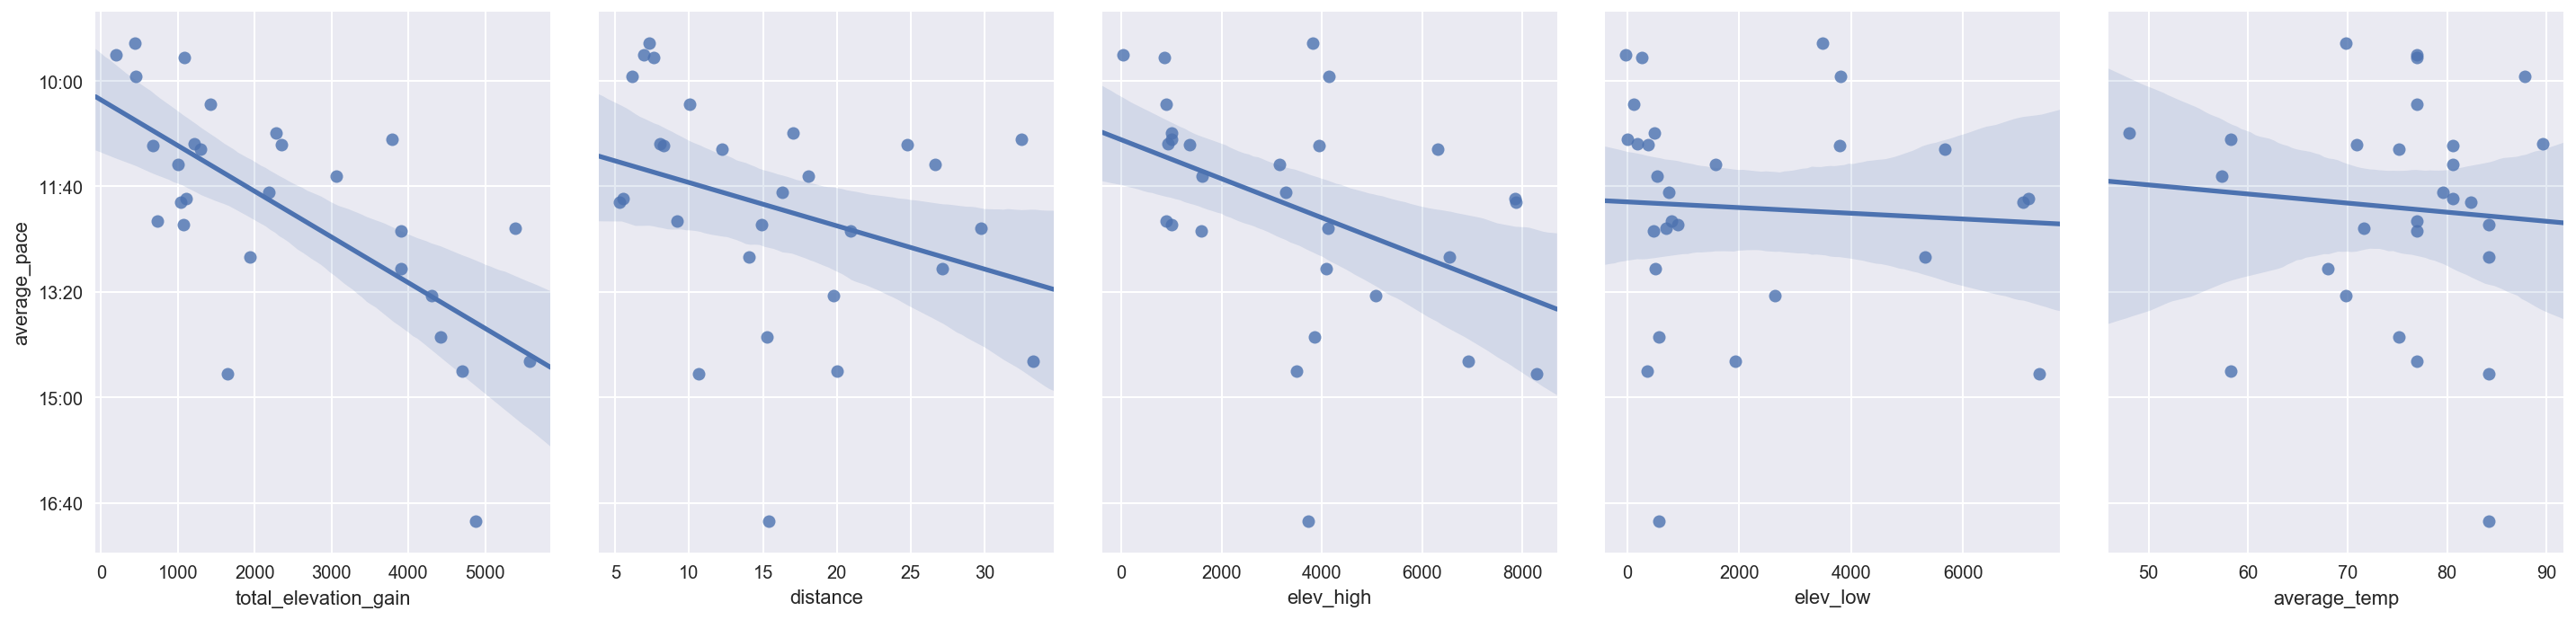

In [8]:
x_vars = ["total_elevation_gain", "distance", "elev_high", "elev_low", "average_temp"]

g = sns.pairplot(
    data = activities,
    x_vars = x_vars, 
    y_vars = ["average_pace"],
    size = 5,
    aspect = 0.8,
    kind = "reg",
)

for ax in g.axes.flat:
    ax.invert_yaxis()
    ax.yaxis.set_major_formatter(hms_tickformater)
    
plt.show()

This shows the kind of correllation around elevation and distance I expected, but less strong for the other fields. Here's another way of looking at it, using `statsmodels` tool for generating a correllation plot.

(I don't entirely understand this code; I've cargo-culted it from the docs somewhat.)

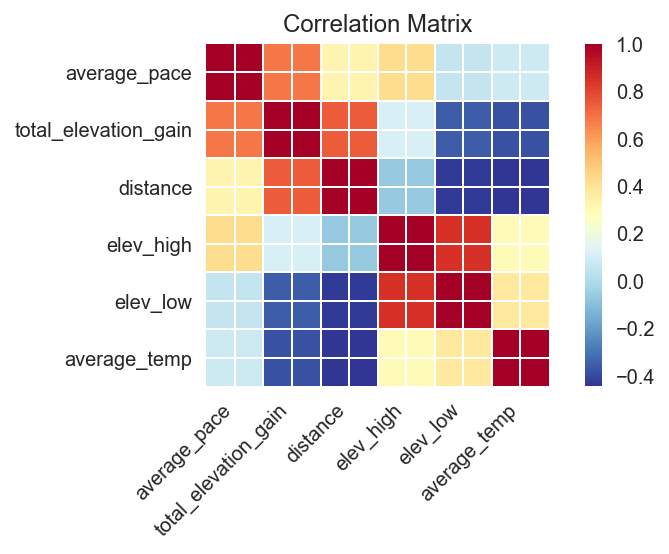

In [9]:
corr_df = activities.filter(['average_pace'] + x_vars, axis="columns")
corr_df.dropna(inplace=True)
corr_matrix = np.corrcoef(corr_df.T)
sm.graphics.plot_corr(corr_matrix, xnames=corr_df.columns)
plt.show()

So elevation gain is the strongest correllation factor -- which matches my intution. Distance correllates, which also makes sense: I slow down as I go longer. Moving time doesn't count, as pace is derrived from that. 

Temperature is slightly correllated, but weak (which is surprising; I'd thought it'd have a stronger effect).

`elev_high` (max elevation) correllates more strongly than `elev_low` (min elevation) which is... weird. I'm going to leave that out of the final model because I don't understand it, even though leaving it in would result in a tighter CI.

Let's do a regression and see how we did:

In [30]:
pace_model = smf.ols('average_pace ~ total_elevation_gain + distance + average_temp', data=activities).fit()
pace_model.rsquared

0.64837369098001574

Not bad! Not great, but not bad.

## Project pace for TRT

Based on that, let's project my predicted pace for TRT. To do this, I need to feed gain, distance, and temp back into `pace_model`.

Distance and elevation gain are easy, since those are fixed: TRT is 50 miles, with about 9,200 feet of elevation gain.

Temperature is the variable bit, so I'll use the Dark Sky API to grab a forecast, re-using the code above that pulled historic temp data.

(39.2193, -119.9043 is the location for the Tunnel Creek aid station, at 8000 feet and about the "middle" of the course.)

In [31]:
race_start = dt.datetime(2017, 7, 15, 6, 0, 0)
race_finish = race_start + dt.timedelta(hours=16, minutes=130)
forecast = get_forecast_temperature(39.2193, -119.9043, race_start, race_finish)
forecast

TempForecast(min=56.37, mean=69.64333333333333, max=78.24)

In [32]:
@attr.s
class PredictionPaceResult:
    lower_ci = attr.ib()
    mean = attr.ib()
    upper_ci = attr.ib()
    
def predict_pace(model, distance, total_elevation_gain, forecast):
    prediction = model.get_prediction({
        "distance": distance, 
        "total_elevation_gain": total_elevation_gain, 
        "average_temp": forecast.mean
    })
    lower, upper = prediction.conf_int()[0]
    return PredictionPaceResult(
        lower_ci = dt.timedelta(seconds=lower),
        mean = dt.timedelta(seconds=prediction.predicted_mean[0]),
        upper_ci = dt.timedelta(seconds=upper),
    )

In [33]:
prediction = predict_pace(pace_model, 50, 9200, forecast)

In [34]:
print("Projected finish: {} ({}/mile)".format(
    format_hms(prediction.mean * 50),
    format_hms(prediction.mean)
))

print("95% confidance interval: {} - {} ({} - {}/mile)".format(
    format_hms(prediction.lower_ci * 50),
    format_hms(prediction.upper_ci * 50),
    format_hms(prediction.lower_ci),
    format_hms(prediction.upper_ci),
))

Projected finish: 14:11:40 (17:02/mile)
95% confidance interval: 12:27:56 - 15:55:25 (14:57 - 19:06/mile)


I'm pretty OK with this! Last year I finished Bryce 50 in 14:20, and I'll be happy with something similar or a bit faster. 

And the CI seems reasonable: I do think a sub-13 is possible if I have a great day, but unlikely. And 16:30 is the cutoff, so this projection makes it seem like even if I have a pretty terrible day I can still get it done.

### How much does the temperature affect the projection?

Since the temperature is a forecast, and causes a fair bit of variance in the result, let's take a look at what hotter and cooler temps would mean to the projection:

In [35]:
def plot_race_prediction(model, distance, gain, temps, forecast, ax):
    # generate a projection for each °F for a wide range
    data = [{"distance": distance, "total_elevation_gain": gain, "average_temp": t} for t in temps]
    temp_range_prediction = model.get_prediction(pd.DataFrame(data), row_labels=temps)

    # The "summary frame" contains means and CI, as well as a bunch of other data.
    # Only keep the fields I care about.
    sf = pd.DataFrame(temp_range_prediction.summary_frame())
    sf = sf.filter(["mean", "mean_ci_upper", "mean_ci_lower"], axis="columns")

    # Scale this up to be finish times - makes the chart look cleaner
    sf['mean'] *= 50
    sf['mean_ci_upper'] *= 50
    sf['mean_ci_lower'] *= 50

    # Basic plot options and axis
    ax.set_xlabel("Temperature (°F)", size=18)
    ax.set_ylabel("Projected Finish Time", size=18)
    ax.tick_params(labelsize=16)

    # Plot mean as a line, with a shaded CI
    ax.plot(sf["mean"], linewidth=3, color="C0")
    ax.plot(sf["mean_ci_upper"], color="C1", linestyle="dashed", linewidth=2, label="95% CI")
    ax.plot(sf["mean_ci_lower"], color="C1", linestyle="dashed", linewidth=2, label=None)
    ax.fill_between(temps, sf["mean_ci_lower"], sf["mean_ci_upper"], color="black", alpha=0.3)

    # Plot current forecast temperature
    ax.axvline(forecast.mean, color="C3", linestyle="dashed", label="forecast")

    # Format yaxis ticks to show time in HH:MM instead of raw seconds
    @ax.yaxis.set_major_formatter
    @mpl.ticker.FuncFormatter
    def format_yaxis(x, pos):
        finish_time = format_hms(dt.timedelta(seconds=x))
        pace = format_hms(dt.timedelta(seconds=x/50))
        return f"{finish_time}\n({pace}/mi)"

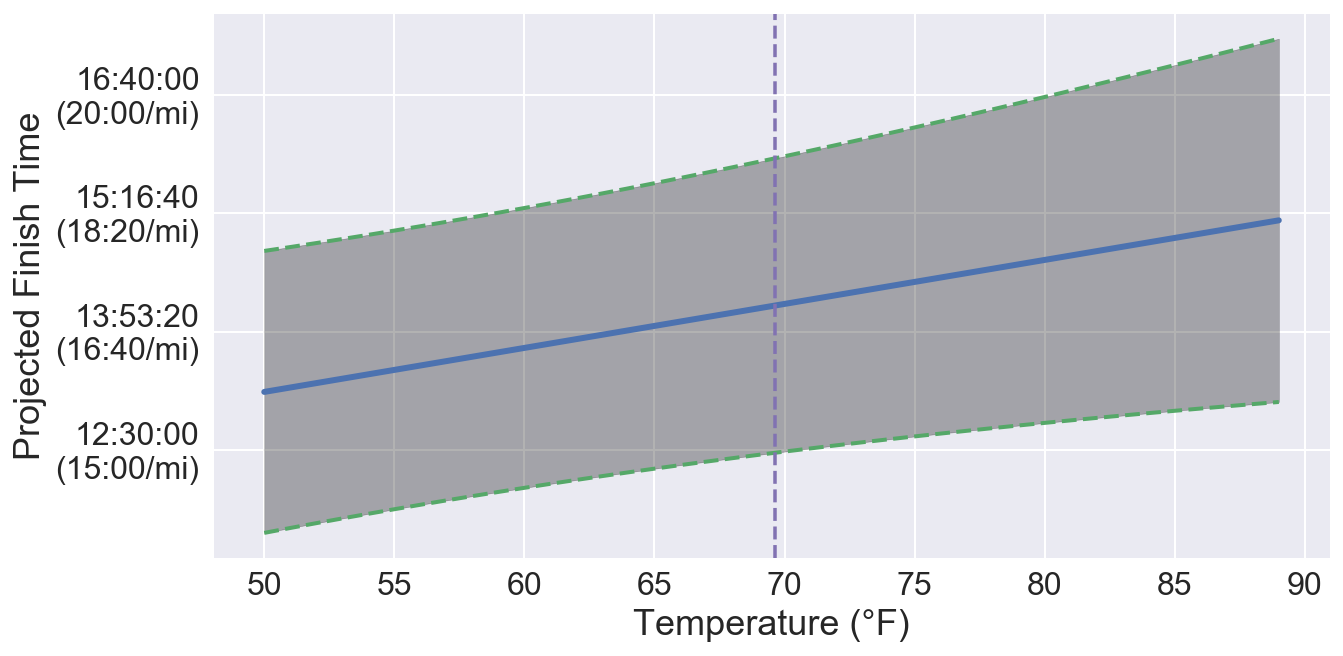

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_race_prediction(model=pace_model, distance=50, gain=9200, 
                     temps=range(50,90), forecast=forecast, ax=ax)
plt.show()

# Part 2: figuring out relative difficulty for each section

Next, pull last year's splits from UltraSignup, and analyze the relative difficulty of each segment. That is, the race is far from flat (for example: there's a 1700' climb between miles 30 and 32 where I'll be moving far slower than average), so to get more accurate projected splits I'll want to know how much harder or easier each bit is.

Start out by defining some simple data structures to hold the specifics about the race. This is purely about readability down below.

In [17]:
@attr.s
class AidStation:
    name = attr.ib()
    distance = attr.ib()
    
    label = attr.ib()
    @label.default
    def default_label(self):
        return re.sub(r"[^a-z0-9]+", "_", self.name.lower()).rstrip('_')
    
    next = attr.ib(repr=False, init=False, cmp=False)
    prev = attr.ib(repr=False, init=False, cmp=False)
        
@attr.s
class RaceData:
    stations = attr.ib(default=attr.Factory(list))
    
    @classmethod
    def from_stations_and_distances(cls, split_distances):
        pc = cls(stations=[AidStation("Start", 0)])
        
        prev = pc.stations[0]
        for (name, distance) in split_distances:
            station = AidStation(name, distance)
            pc.stations.append(station)
            station.prev = prev
            prev.next = station
            prev = station
        
        return pc
    
    def get_by_name(self, name):
        return next(s for s in self.stations if s.name == name)
    
    def get_by_label(self, label):
        return next(s for s in self.stations if s.label == label)
    
split_distances = [
    ("Hobart (1)",       7),
    ("Tunnel Creek (1)", 12),
    ("Red House",        15),
    ("Tunnel Creek (2)", 18.5),
    ("Bull Wheel (1)",   21.5),
    ("Diamond Peak",     30),
    ("Bull Wheel (2)",   32),
    ("Tunnel Creek (3)", 35),
    ("Hobart (2)",       40),
    ("Snow Valley Peak", 43),
    ("Spooner Summit",   48.3),
    ("Finish",           50),
]
TRT = RaceData.from_stations_and_distances(split_distances)

## Read splits from the 2016 results on ultrasignup

This could be improved if I could find more splits, but so far I've only been able to find splits from 2016.

In [18]:
raw_data = pd.read_html("http://ultrasignup.com/event_splits.aspx?did=35091", header=0)[0]

## Clean up data

### Drop columns, rename fields, convert types

In [38]:
# Drop unused columns
splits = raw_data.drop(["Unnamed: 0", "Unnamed: 1"], axis="columns")

# Drop names to avoid scattering people's PII even further across the web
splits.drop(["first_name", "last_name"], axis="columns", inplace=True)

# Drop DNFs and people who missed splits
splits.dropna(inplace=True)

# Clean up split fields: Rename split fields to be easier to type, and to 
# match aid station labels (making future lookups easier).
split_renames = {
    "TC Red House1": "split_" + TRT.get_by_name("Tunnel Creek (2)").label,
    "Diamond Peak1": "split_" + TRT.get_by_name("Diamond Peak").label,
    "TC Diamond1":   "split_" + TRT.get_by_name("Tunnel Creek (3)").label,
    "Snow Valley1":  "split_" + TRT.get_by_name("Snow Valley Peak").label,
    "Finish1":       "split_" + TRT.get_by_name("Finish").label,
}
splits.rename(columns=split_renames, inplace=True)

# Convert split fields to timedeltas.
for field in split_renames.values():
    splits[field] = splits[field].map(pd.to_timedelta)

# rename a few other fields just to be consistant
case_fixes = {x: x.lower() for x in splits.columns if x[0].isupper()}
splits.rename(inplace=True, columns=case_fixes)
    
# How'd we do?
splits.head()

,place,gender,age,bib,split_tunnel_creek_2,split_diamond_peak,split_tunnel_creek_3,split_snow_valley_peak,split_finish
0,1,M,32,496,03:05:09,04:54:14,06:11:48,07:50:54,08:52:47
1,2,M,34,369,03:08:47,05:07:25,06:20:57,08:02:52,09:07:52
2,3,M,37,339,03:07:41,05:05:30,06:26:18,08:08:39,09:13:40
4,5,M,35,423,03:10:08,05:08:37,06:34:50,08:19:54,09:24:01
5,6,F,27,324,03:19:24,05:20:55,06:42:10,08:21:41,09:29:53


### Add pace fields

For each split, calculate a pace for that segment, as well as a "relative pace": the ratio of that split's pace to the overall average pace for the race.

In [39]:
# Overall finish pace
splits["average_pace"] = splits.split_finish / TRT.get_by_label("finish").distance

# Finish pace for each split
# FIXME: I'd love to do this more dynamically but 
split_cols = [col for col in splits.columns if col.startswith("split_")]
split_stations = [TRT.get_by_label(l[6:]) for l in split_cols]

col_stations = zip(split_cols, split_stations)
col_stations = chain([(None, TRT.get_by_label('start'))], col_stations)

for ((prev_col, prev_station), (col, station)) in windowed(col_stations, 2):
    prev_split = splits[prev_col] if prev_col else dt.timedelta(0)
    splits[f"pace_{station.label}"] = (splits[col] - prev_split) / (station.distance - prev_station.distance)
    splits[f"rel_pace_{station.label}"] = splits[f"pace_{station.label}"] / splits["average_pace"]
    
splits.head()

,place,gender,age,bib,split_tunnel_creek_2,split_diamond_peak,split_tunnel_creek_3,split_snow_valley_peak,split_finish,average_pace,pace_tunnel_creek_2,rel_pace_tunnel_creek_2,pace_diamond_peak,rel_pace_diamond_peak,pace_tunnel_creek_3,rel_pace_tunnel_creek_3,pace_snow_valley_peak,rel_pace_snow_valley_peak,pace_finish,rel_pace_finish
0,1,M,32,496,03:05:09,04:54:14,06:11:48,07:50:54,08:52:47,00:10:39.340000,00:10:00.486486,0.939229,00:09:29.130434,0.890184,00:15:30.800000,1.455876,00:12:23.250000,1.162527,00:08:50.428571,0.829650
1,2,M,34,369,03:08:47,05:07:25,06:20:57,08:02:52,09:07:52,00:10:57.440000,00:10:12.270270,0.931295,00:10:18.956521,0.941465,00:14:42.400000,1.342176,00:12:44.375000,1.162654,00:09:17.142857,0.847443
2,3,M,37,339,03:07:41,05:05:30,06:26:18,08:08:39,09:13:40,00:11:04.400000,00:10:08.702702,0.916169,00:10:14.695652,0.925189,00:16:09.600000,1.459362,00:12:47.625000,1.155366,00:09:17.285714,0.838780
4,5,M,35,423,03:10:08,05:08:37,06:34:50,08:19:54,09:24:01,00:11:16.820000,00:10:16.648648,0.911097,00:10:18.173913,0.913351,00:17:14.600000,1.528619,00:13:08,1.164268,00:09:09.571428,0.811991
5,6,F,27,324,03:19:24,05:20:55,06:42:10,08:21:41,09:29:53,00:11:23.860000,00:10:46.702702,0.945665,00:10:34,0.927090,00:16:15,1.425730,00:12:26.375000,1.091415,00:09:44.571428,0.854812




Take a look at what these relative paces look like:

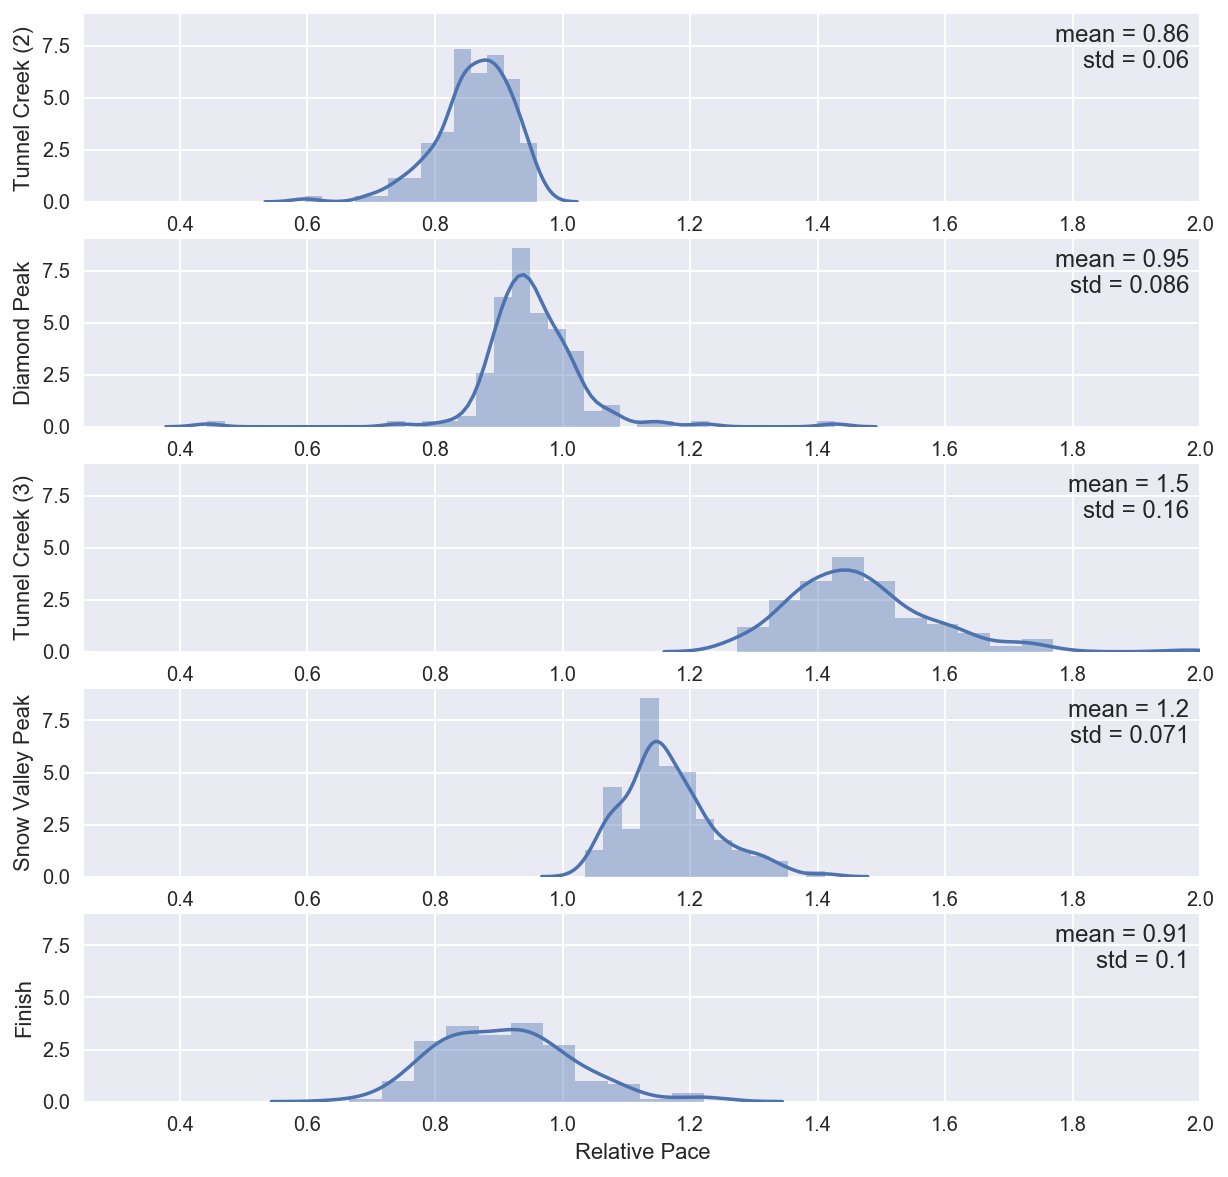

In [40]:
def annotate_stats(data, ax):
    """Helper: add an annotation to the upper right of ax showing mean/std of data"""
    text = "mean = {mean:.2g}\nstd = {std:.2g}".format(**data.describe())
    ax.text(.99, .95, text, ha="right", va="top", transform=ax.transAxes)

rel_pace_cols = [col for col in splits.columns if col.startswith('rel_pace')]
fig, axes = plt.subplots(len(rel_pace_cols), 1, figsize=(10, 10), squeeze=True)

for (col, ax) in zip(rel_pace_cols, axes):
    sns.distplot(splits[col], ax=ax, color="C0")
    ax.set_xlim(left=0.25, right=2)
    ax.set_ylim(bottom=0, top=9)
    ax.set_ylabel(TRT.get_by_label(col.replace('rel_pace_', '')).name)
    annotate_stats(splits[col], ax)

axes[-1].set_xlabel("Relative Pace")
    
plt.show()

Neat, those are all fairly normal-looking distributions, which means using means (and perhaps normal-based CIs) to project my paces seems reasonable.

But, do these relative paces differ meaningfully for runners at the front of the pack vs the back of the pack? This might happen if, for example, better runners are capable of running faster towards the end of the race. There's certainly a lot more variability in that final split -- look at how flat that curve is. Does that veriability 

To find out, I'll split the data into quartiles and see if things look different for different skilled runners:

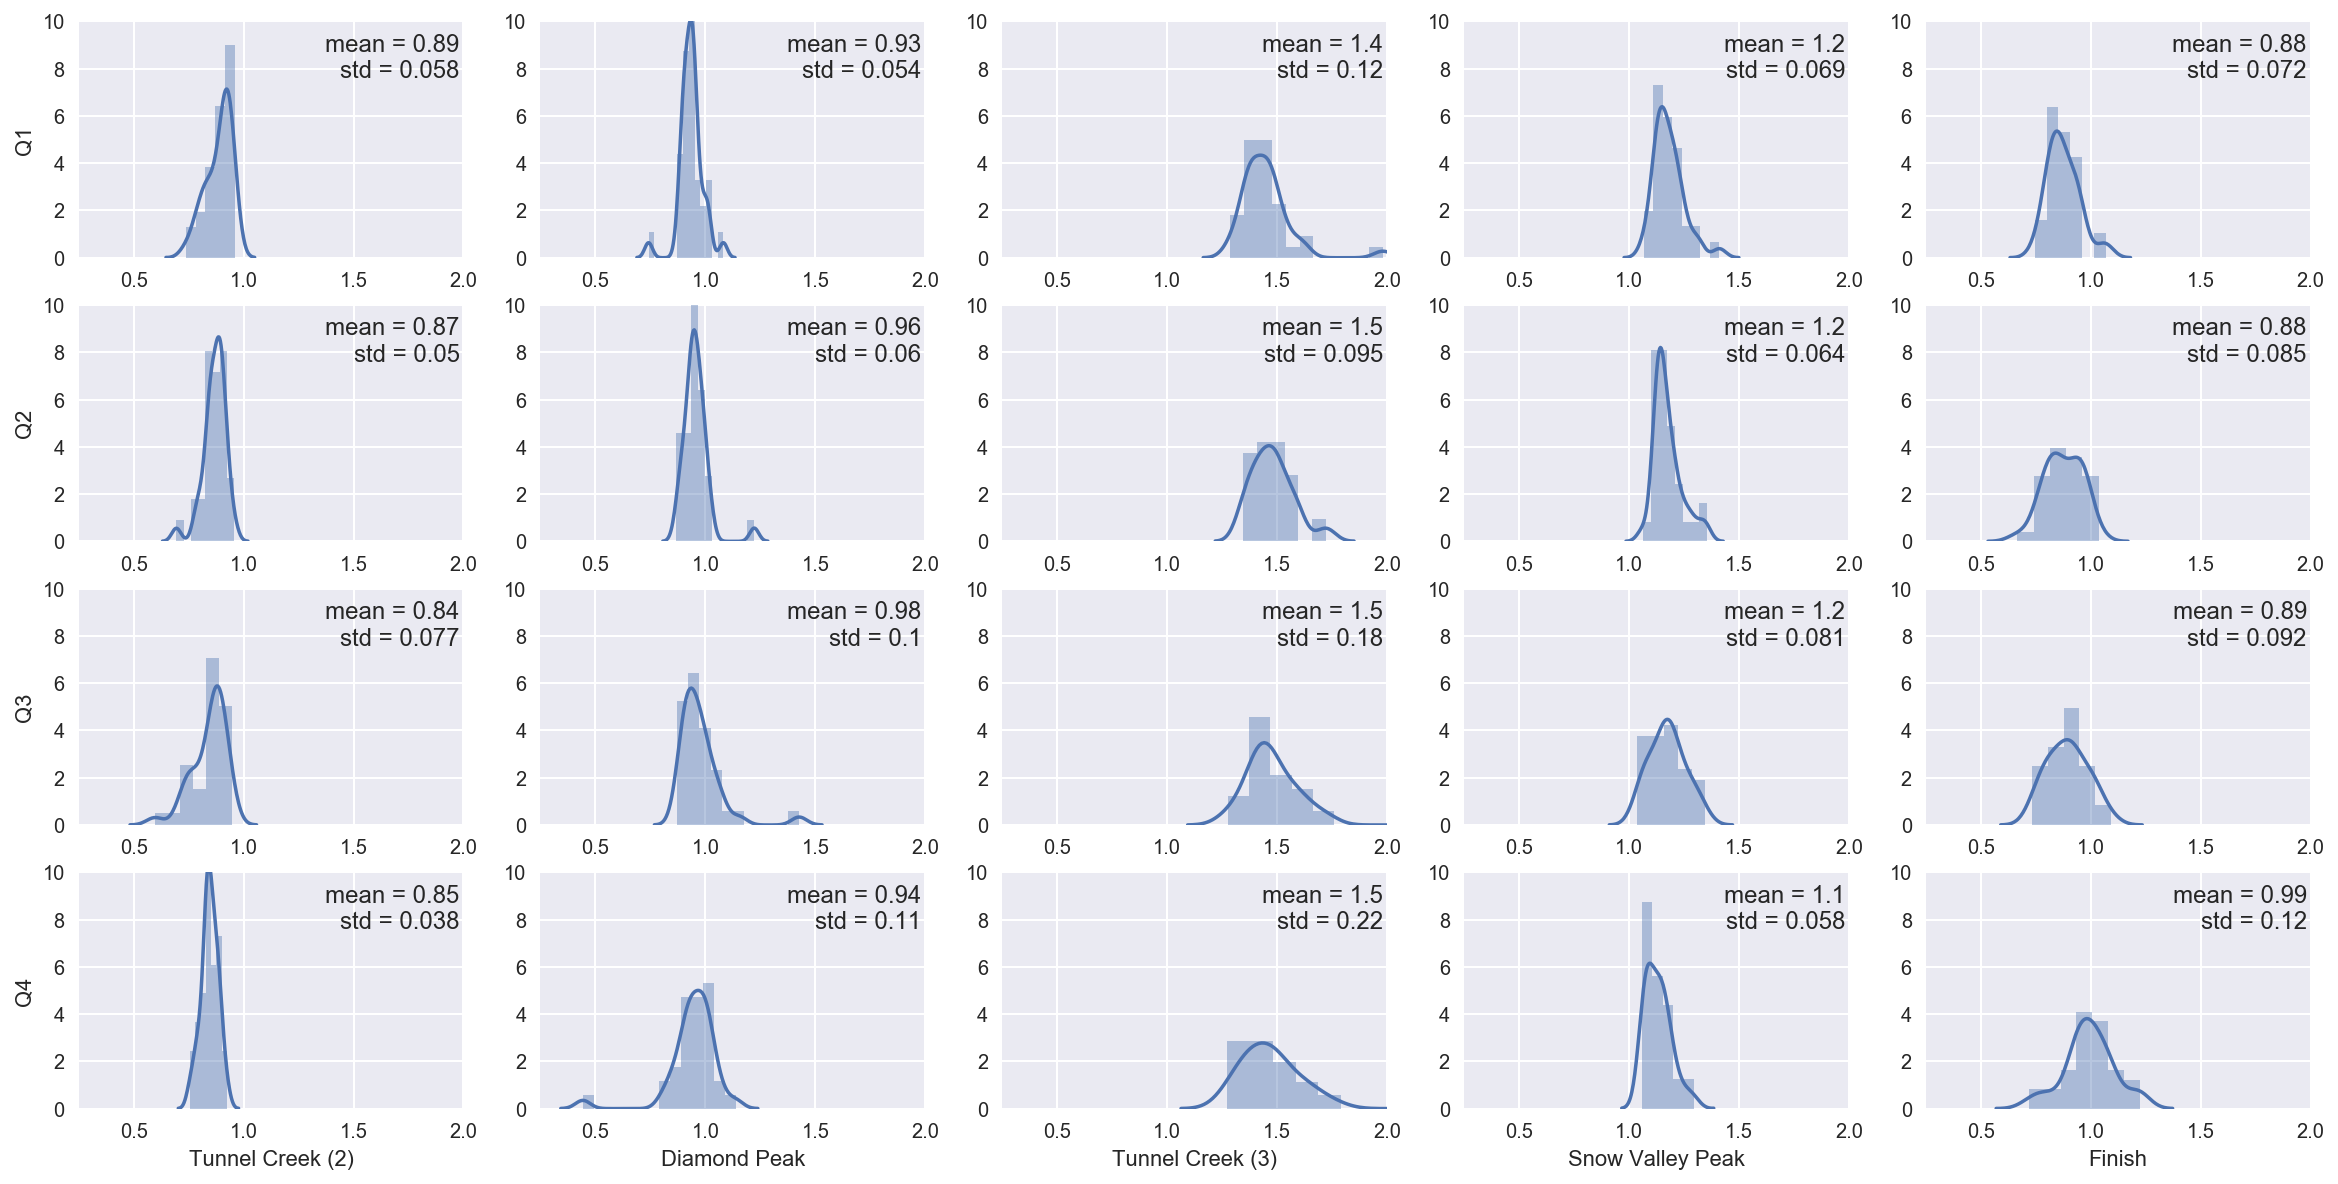

In [41]:
# Add a quantile field to splits, just based on place. 
# This divides into first N finishers, next N, etc.
quantiles = ['q1', 'q2', 'q3', 'q4']
splits['quantile'] = pd.qcut(splits['place'], q=len(quantiles), labels=quantiles)

# Going to plot each quantile as a row, and each aid station as a column
# This makes it easy to read down
fig, axes = plt.subplots(nrows=len(quantiles), ncols=len(rel_pace_cols), figsize=(20,10))

for quantile, row_axes in zip(quantiles, axes):
    for col, ax in zip(rel_pace_cols, row_axes):
        sns.distplot(splits[splits["quantile"] == quantile][col], ax=ax, axlabel=False)
        ax.set_xlim(left=0.25, right=2)
        ax.set_ylim(bottom=0, top=10)
        annotate_stats(splits[splits["quantile"] == quantile][col], ax)

# Add quantile lables to the first (left) graph in each row
for i,q in enumerate(quantiles):
    axes[i][0].set_ylabel(q.upper())

# And add station labels to the last (bottom) graph in each column
for i,col in enumerate(rel_pace_cols):
    axes[-1][i].set_xlabel(TRT.get_by_label(col.replace('rel_pace_', '')).name)
    
plt.show()

There's a few interesting stories this data can tell! Check out how slower runner show more variability late in the race (see how the histogram "flattens" out for the final split).

But for the purposes of projecting _my_ paces: the differences between the quartiles isn't particularly big; I could use overall averages and probably get as accurate a prediction as using a more targeted quartile. But, I might as well select the quartile I'd expect to finish in, given the projected pace above:

In [42]:
for q in quantiles:
    finish_times = splits[splits["quantile"] == q]["split_finish"]
    print("{q}: {fmin} - {fmax}".format(
        q = q,
        fmin = format_hms(min(finish_times)),
        fmax = format_hms(max(finish_times))
    ))

q1: 8:52:47 - 12:14:42
q2: 12:16:04 - 13:52:28
q3: 13:55:19 - 15:43:32
q4: 15:44:37 - 18:40:24


This puts me in the front of Q3, which sounds about right for my general racing prowess. If I have a great day, I could finish in the top 50%, but only by a bit. Seems legit. So I'll go with Q3 numbers to generate my pace chart.

# Part 3: Generate _my_ split chart

Now that I have the data, pull it all together and generate a pace chart.

Calculate relative difficulty factors for each split given the data. I'll use the third quartile for this, even though it's not widely different from using the overall mean.

In [43]:
quantile_splits = splits[splits["quantile"] == "q3"]
split_scale_factors = {col: quantile_splits[col].mean() for col in rel_pace_cols}
split_scale_factors

{'rel_pace_diamond_peak': 0.9780473121480483,
 'rel_pace_finish': 0.89460918628622388,
 'rel_pace_snow_valley_peak': 1.1750865129793813,
 'rel_pace_tunnel_creek_2': 0.8425932782580533,
 'rel_pace_tunnel_creek_3': 1.5003047709335515}

Since we don't have splits at every aid station, we need to map which relative paces to use for which sections. This could probably be done more elegantly...

In [25]:
trt_scale_factors = {    
    "Hobart (1)":       split_scale_factors["rel_pace_tunnel_creek_2"],
    "Tunnel Creek (1)": split_scale_factors["rel_pace_tunnel_creek_2"],
    "Red House":        split_scale_factors["rel_pace_tunnel_creek_2"],
    "Tunnel Creek (2)": split_scale_factors["rel_pace_tunnel_creek_2"],
    "Bull Wheel (1)":   split_scale_factors["rel_pace_diamond_peak"],
    "Diamond Peak":     split_scale_factors["rel_pace_diamond_peak"],
    "Bull Wheel (2)":   split_scale_factors["rel_pace_tunnel_creek_3"],
    "Tunnel Creek (3)": split_scale_factors["rel_pace_tunnel_creek_3"],
    "Hobart (2)":       split_scale_factors["rel_pace_snow_valley_peak"],
    "Snow Valley Peak": split_scale_factors["rel_pace_snow_valley_peak"],
    "Spooner Summit":   split_scale_factors["rel_pace_finish"],
    "Finish":           split_scale_factors["rel_pace_finish"],
}

Some utilities to generate and show a split chart:

In [26]:
@attr.s
class PaceChartLine:
    station = attr.ib()
    pace = attr.ib(default=None)
    
    @property
    def pace_str(self):
        return format_hms(self.pace)
    
    @property
    def seg_time(self):
        return self.pace * (self.station.distance - self.station.prev.distance)
    
    @property
    def seg_time_str(self):
        return format_hms(self.seg_time)

def generate_pace_chart(race_data, scale_factors, average_pace):
    # Skip the starting line, since it doesn't have a pace
    start_station, *stations = iter(race_data.stations)
    
    for station in stations:
        scale_factor = scale_factors[station.name]
        yield PaceChartLine(station=station, pace = average_pace * scale_factor)
        
def print_pace_chart(chart, start_time):
    line_format = ("{line.station.name:20s} {line.station.distance:<6g} "
                   "{line.pace_str:>5s} {line.seg_time_str:>10s} {elapsed:>9s} "
                   "{eta:>9s}")
    
    print("Aid Station          Dist.  Pace   Seg. Time  Elapsed   ETA   ")
    print("-------------------  -----  -----  ---------  --------  --------")
    print("Start                0                                 {:>9s}".format(start_time.strftime("%-I:%M %p").lower()))
    
    elapsed = dt.timedelta(0)
    for line in chart:
        elapsed += line.seg_time
        eta = (start_time + elapsed).strftime("%-I:%M %p").lower()
        print(line_format.format(line=line, elapsed=format_hms(elapsed), eta=eta))
        

Generate a pace chart for my predicted time:

In [45]:
chart = generate_pace_chart(TRT, trt_scale_factors, prediction.mean)
print_pace_chart(chart, start_time=race_start)

Aid Station          Dist.  Pace   Seg. Time  Elapsed   ETA   
-------------------  -----  -----  ---------  --------  --------
Start                0                                   6:00 am
Hobart (1)           7      14:21    1:40:28   1:40:28   7:40 am
Tunnel Creek (1)     12     14:21    1:11:45   2:52:13   8:52 am
Red House            15     14:21      43:03   3:35:17   9:35 am
Tunnel Creek (2)     18.5   14:21      50:14   4:25:31  10:25 am
Bull Wheel (1)       21.5   16:39      49:58   5:15:29  11:15 am
Diamond Peak         30     16:39    2:21:36   7:37:06   1:37 pm
Bull Wheel (2)       32     25:33      51:06   8:28:12   2:28 pm
Tunnel Creek (3)     35     25:33    1:16:40   9:44:52   3:44 pm
Hobart (2)           40     20:00    1:40:04  11:24:57   5:24 pm
Snow Valley Peak     43     20:00    1:00:02  12:25:00   6:25 pm
Spooner Summit       48.3   15:14    1:20:45  13:45:46   7:45 pm
Finish               50     15:14      25:54  14:11:40   8:11 pm


And,  use the confidance intervals from the prediction above to get a handle on lower and upper bounds:

In [46]:
lower_ci_chart = generate_pace_chart(TRT, trt_scale_factors, prediction.lower_ci)
upper_ci_chart = generate_pace_chart(TRT, trt_scale_factors, prediction.upper_ci)

print("Lower CI paces:\n")
print_pace_chart(lower_ci_chart, race_start)
print("\nUpper CI paces:\n")
print_pace_chart(upper_ci_chart, race_start)

Lower CI paces:

Aid Station          Dist.  Pace   Seg. Time  Elapsed   ETA   
-------------------  -----  -----  ---------  --------  --------
Start                0                                   6:00 am
Hobart (1)           7      12:36    1:28:13   1:28:13   7:28 am
Tunnel Creek (1)     12     12:36    1:03:01   2:31:14   8:31 am
Red House            15     12:36      37:48   3:09:03   9:09 am
Tunnel Creek (2)     18.5   12:36      44:06   3:53:10   9:53 am
Bull Wheel (1)       21.5   14:37      43:53   4:37:03  10:37 am
Diamond Peak         30     14:37    2:04:21   6:41:25  12:41 pm
Bull Wheel (2)       32     22:26      44:53   7:26:18   1:26 pm
Tunnel Creek (3)     35     22:26    1:07:19   8:33:38   2:33 pm
Hobart (2)           40     17:34    1:27:53  10:01:31   4:01 pm
Snow Valley Peak     43     17:34      52:43  10:54:15   4:54 pm
Spooner Summit       48.3   13:22    1:10:55  12:05:11   6:05 pm
Finish               50     13:22      22:44  12:27:56   6:27 pm

Upper CI 

# Part 4: How accurate was this projection?

TBD. Check back after the race.